# This program is to calculate random forest permutations for the 24 good GCs, using the 19 chemical abundances optionally 3 kinmatic parameters as potential features

This notebook is split into 2 sections: one where I classified stars in each GC as 'Field' or 'Cluster' and used only chem abundances as features, and one where I classified stars as 'Field', 'Ctrl' or 'ET' and used both chem and kin.

MAIN ISSUE: When I repeat the same run, the importances come out differently. This is observed even when using the same random seed. The only thing that stays consistent is that the same features generally make up the majority of a GC's decrease in accuracy.

OTHER ISSUES: Many of the importances come out 0 or negative. For the purposes of plotting I've set all negative values to 0

In [1]:
# General analysis/plotting packages:
import matplotlib.pyplot as plt
import numpy as np
import math
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from matplotlib import rc
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
from collections import Counter

# Specific t-SNE/visualization packages:
from sklearn.manifold import TSNE
from shapely.geometry import Point, Polygon

# UMAP shit
# Import UMAP
import umap.umap_ as umap

# Try using SKLEARN's StandardScaler to standardize the data
from sklearn.preprocessing import StandardScaler

# I/O
import sys

# OS
import os

# dbscan
from sklearn.cluster import DBSCAN

# tqdm
from tqdm.notebook import tqdm

# KDTree
from scipy.spatial import cKDTree

# mode
from scipy import stats as st

# music
#import simpleaudio as sa

# time
import time

# save and load
import pickle

# optimization
from scipy.optimize import minimize

# best fit
from scipy.odr import *

# correlation coeff
from scipy.stats import pearsonr
from scipy.stats import spearmanr
from scipy.stats import kendalltau

# fuck matplotlib warnings
import warnings

#random forest
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance

In [2]:
abundance_labels= ['FE_H', 'C_FE',  'Cl_FE', 'N_FE', 'O_FE', 'MG_FE', 
                'AL_FE', 'SI_FE', 'P_FE', 'S_FE', 'K_FE', 'CA_FE', 
                'TI_FE', 'TIII_FE','V_FE', 'CR_FE', 'MN_FE', 'CO_FE','NI_FE']

abundance_labels_kin= ['FE_H', 'C_FE',  'Cl_FE', 'N_FE', 'O_FE', 'MG_FE', 
                'AL_FE', 'SI_FE', 'P_FE', 'S_FE', 'K_FE', 'CA_FE', 
                'TI_FE', 'TIII_FE','V_FE', 'CR_FE', 'MN_FE', 'CO_FE','NI_FE', 'RV', 'PMRA', 'PMDEC']

good_GC_inds=[0,1,3,4,5,6,7,8,9,10,11,12,14,15,16,17,18,21,27,29,30,31,32,33]

GC_names = ['NGC_104','NGC_288','NGC_362','NGC_1851','NGC_1904','NGC_2808',
          'NGC_3201','NGC_4590','NGC_5024','NGC_5139','NGC_5272','NGC_5904',
          'NGC_6121','NGC_6171','NGC_6205','NGC_6218','NGC_6254','NGC_6273',
          'NGC_6341','NGC_6380','NGC_6388','NGC_6397','NGC_6441','Ter_9',
          'NGC_6522','NGC_6544','NGC_6553','NGC_6656','NGC_6715','NGC_6752',
          'NGC_6809','NGC_6838','NGC_7078','NGC_7089']

good_GC_names=[]
for i in good_GC_inds:
    good_GC_names.append(GC_names[i])

## Permutations with 2 classifications
In this section, I classify the stars in each GC as 'Field' or 'Cluster', 'Cluster' encompassing both ETs and control stars.

Kinematic parameters here are excluded, so only the 19 chemical abundances are used as features.

In [18]:
with open('Permutations_class_and_params_files/good_GC_class_2', 'rb') as f:
    good_GC_class_2 = pickle.load(f)
    
with open('Permutations_class_and_params_files/good_GC_params_nokin', 'rb') as f:
    good_GC_params_nokin = pickle.load(f)

In [5]:
#This is where the permutation importances are calculated. If there is a mistake in the code 
#causing inconsistencies run by run, its in this cell.

model = RandomForestClassifier()

GC_importances_2=[]
for i in range(len(good_GC_params_nokin)):
    print('working on', good_GC_names[i])
    x_train, x_test, y_train, y_test = train_test_split(good_GC_params_nokin[i], good_GC_class_2[i], 
                                                        train_size=.8)
    
    model.fit(x_train, y_train)
    result = permutation_importance(model, x_test, y_test, n_repeats=20, random_state=42)
    forest_importances = pd.Series(result.importances_mean, index=abundance_labels[0:19])
    GC_importances_2.append(forest_importances)

working on NGC_104
working on NGC_288
working on NGC_1851
working on NGC_1904
working on NGC_2808
working on NGC_3201
working on NGC_4590
working on NGC_5024
working on NGC_5139
working on NGC_5272
working on NGC_5904
working on NGC_6121
working on NGC_6205
working on NGC_6218
working on NGC_6254
working on NGC_6273
working on NGC_6341
working on NGC_6397
working on NGC_6656
working on NGC_6752
working on NGC_6809
working on NGC_6838
working on NGC_7078
working on NGC_7089


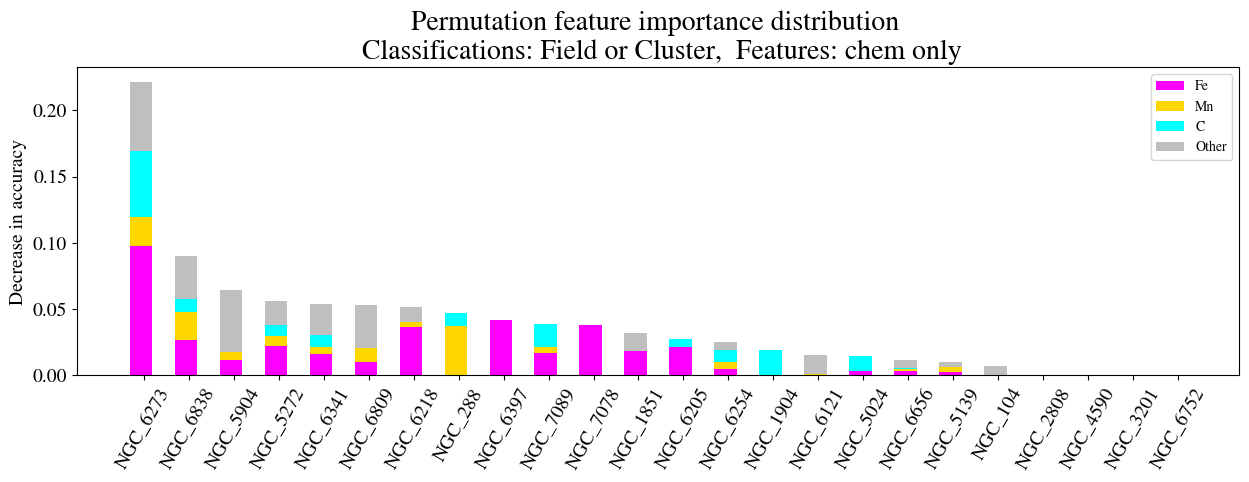

In [12]:
#For organizing the plot

Fe = []; Mn = []; C = []; Other = []

for GC in GC_importances_2:

    if GC[0]>0:
        Fe.append(GC[0])
    else:
        Fe.append(0)
        
    if GC[1]>0:
        C.append(GC[1])
    else:
        C.append(0)
        
    if GC[16]>0:
        Mn.append(GC[16])
    else:
        Mn.append(0)

    others=np.sum(GC) - (GC[0]+GC[1]+GC[16])
    if others>0:
        Other.append(others)
    else:
        Other.append(0)
    
Fe = np.array(Fe);Mn=np.array(Mn); C=np.array(C); Other=np.array(Other)

FeMnC = Fe+Mn+C
total=Fe+Mn+C+Other

FeMnC_desc_ind = np.argsort(np.array(FeMnC))
total_desc_ind = list(reversed(np.argsort(total)))

good_GC_names_sorted_total=[];kin_sorted=[];Fe_sorted=[]; Mn_sorted=[]; C_sorted=[]; Other_sorted=[]
for i in total_desc_ind:
    good_GC_names_sorted_total.append(good_GC_names[i])
    Fe_sorted.append(Fe[i]);Mn_sorted.append(Mn[i]);C_sorted.append(C[i])
    Other_sorted.append(Other[i])

kin_sorted=np.array(kin_sorted);
Fe_sorted=np.array(Fe_sorted);Mn_sorted=np.array(Mn_sorted);C_sorted=np.array(C_sorted)
Other_sorted=np.array(Other_sorted)

plt.figure(figsize=(15,4))

bar_width = 0.5
bar_l = np.arange(0, 24)
tick_pos = [i + (bar_width / 8) for i in bar_l]

plt.bar(good_GC_names_sorted_total, Fe_sorted, bottom=0,width=bar_width, label="Fe", color="magenta")
plt.bar(good_GC_names_sorted_total, Mn_sorted, bottom=Fe_sorted, width=bar_width, label="Mn", color="gold")
plt.bar(good_GC_names_sorted_total, C_sorted, bottom=Fe_sorted+Mn_sorted, width=bar_width,label="C",color='cyan')
plt.bar(good_GC_names_sorted_total, Other_sorted, bottom=Mn_sorted+Fe_sorted+C_sorted, width=bar_width, label="Other", color="grey", alpha=.5)

plt.ylabel("Decrease in accuracy", fontsize=14)
plt.legend(loc="best")
plt.xticks(tick_pos, good_GC_names_sorted_total, fontsize=14, rotation=60)
plt.yticks(fontsize=14)

plt.title('Permutation feature importance distribution \n Classifications: Field or Cluster,  Features: chem only', fontsize=20)
plt.ylabel('Decrease in accuracy', fontsize=14)

plt.show()

## Permutations with 3 classifications
In this section, I classify the stars in each GC as 'Field' or 'Ctrl' or 'ET'

3 Kinematic parameters (RV, PMRA, PMDEC) are included along with the 19 chemical abundances, for a total of 22 features.

In [19]:
with open('Permutations_class_and_params_files/good_GC_class_3', 'rb') as f:
    good_GC_class_3 = pickle.load(f)
    
with open('Permutations_class_and_params_files/good_GC_params_kin', 'rb') as f:
    good_GC_params_kin = pickle.load(f)

In [11]:
#This is where the permutation importances are calculated. If there is a mistake in the code 
#causing inconsistencies run by run, its in this cell.

model = RandomForestClassifier()

GC_importances_3=[]
for i in range(len(good_GC_params_kin)):
    print('working on', good_GC_names[i])
    x_train, x_test, y_train, y_test = train_test_split(good_GC_params_kin[i], good_GC_class_3[i], 
                                                        train_size=.8)
    
    model.fit(x_train, y_train)
    result = permutation_importance(model, x_test, y_test, n_repeats=20, random_state=42)
    forest_importances = pd.Series(result.importances_mean, index=abundance_labels_kin[0:22])
    GC_importances_3.append(forest_importances)

working on NGC_104
working on NGC_288
working on NGC_1851
working on NGC_1904
working on NGC_2808
working on NGC_3201
working on NGC_4590
working on NGC_5024
working on NGC_5139
working on NGC_5272
working on NGC_5904
working on NGC_6121
working on NGC_6205
working on NGC_6218
working on NGC_6254
working on NGC_6273
working on NGC_6341
working on NGC_6397
working on NGC_6656
working on NGC_6752
working on NGC_6809
working on NGC_6838
working on NGC_7078
working on NGC_7089


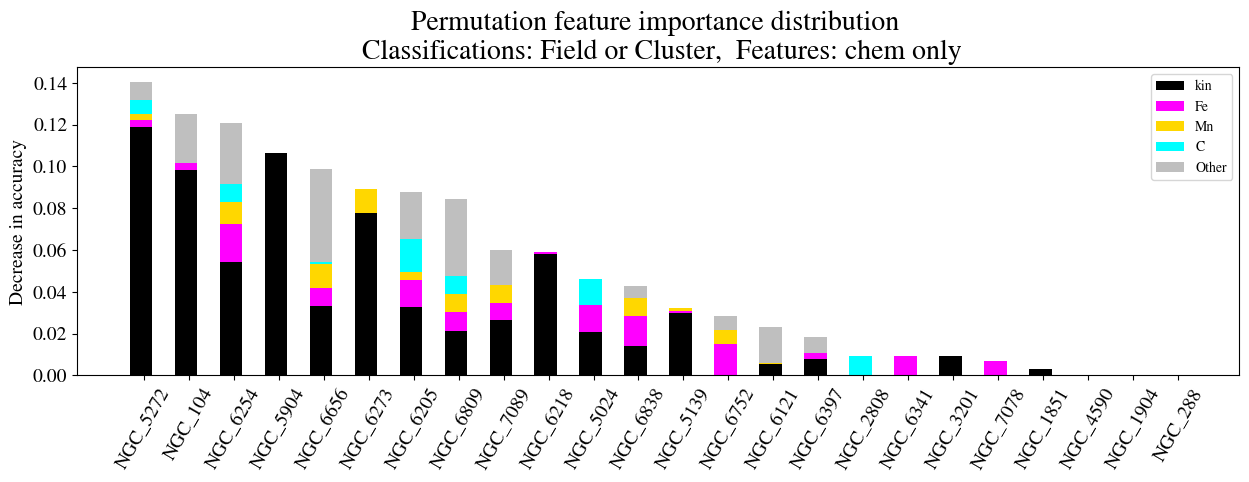

In [17]:
#For organizing the plot

RV=[];PMRA=[];PMDEC=[]; Fe = []; Mn = []; C = []; Other = []

for GC in GC_importances_3:

    if GC[0]>0:
        Fe.append(GC[0])
    else:
        Fe.append(0)
        
    if GC[1]>0:
        C.append(GC[1])
    else:
        C.append(0)
        
    if GC[16]>0:
        Mn.append(GC[16])
    else:
        Mn.append(0)
        
    if GC[19]>0:
        RV.append(GC[19])
    else:
        RV.append(0)
        
    if GC[20]>0:
        PMRA.append(GC[20])
    else:
        PMRA.append(0)
        
    if GC[21]>0:
        PMDEC.append(GC[21])
    else:
        PMDEC.append(0)

    others=np.sum(GC) - (GC[0]+GC[1]+GC[16]+GC[19]+GC[20]+GC[21])
    if others>0:
        Other.append(others)
    else:
        Other.append(0)
    
Fe = np.array(Fe);Mn=np.array(Mn); C=np.array(C); Other=np.array(Other)
RV = np.array(RV); PMRA = np.array(PMRA); PMDEC = np.array(PMDEC)

kin=RV+PMRA+PMDEC
FeMnC = Fe+Mn+C
total=Fe+Mn+C+kin+Other

#FeMnC_desc_ind = np.argsort(np.array(FeMnC))
total_desc_ind = list(reversed(np.argsort(total)))

good_GC_names_sorted_total=[];kin_sorted=[];Fe_sorted=[]; Mn_sorted=[]; C_sorted=[]; Other_sorted=[]
for i in total_desc_ind:
    good_GC_names_sorted_total.append(good_GC_names[i])
    kin_sorted.append(kin[i])
    Fe_sorted.append(Fe[i]);Mn_sorted.append(Mn[i]);C_sorted.append(C[i])
    Other_sorted.append(Other[i])

kin_sorted=np.array(kin_sorted);
Fe_sorted=np.array(Fe_sorted);Mn_sorted=np.array(Mn_sorted);C_sorted=np.array(C_sorted)
Other_sorted=np.array(Other_sorted)

plt.figure(figsize=(15,4))

bar_width = 0.5
bar_l = np.arange(0, 24)
tick_pos = [i + (bar_width / 8) for i in bar_l]

plt.bar(good_GC_names_sorted_total, kin_sorted, width=bar_width, label="kin", color="black")
plt.bar(good_GC_names_sorted_total, Fe_sorted, bottom=kin_sorted,width=bar_width, label="Fe", color="magenta")
plt.bar(good_GC_names_sorted_total, Mn_sorted, bottom=kin_sorted+Fe_sorted, width=bar_width, label="Mn", color="gold")
plt.bar(good_GC_names_sorted_total, C_sorted, bottom=kin_sorted+Fe_sorted+Mn_sorted, width=bar_width,label="C",color='cyan')
plt.bar(good_GC_names_sorted_total, Other_sorted, bottom=kin_sorted+Mn_sorted+Fe_sorted+C_sorted, width=bar_width, label="Other", color="grey", alpha=.5)

plt.ylabel("Decrease in accuracy", fontsize=14)
plt.legend(loc="best")
plt.xticks(tick_pos, good_GC_names_sorted_total, fontsize=14, rotation=60)
plt.yticks(fontsize=14)

plt.title('Permutation feature importance distribution \n Classifications: Field or Ctrl or ET,  Features: chem + kin', fontsize=20)
plt.ylabel('Decrease in accuracy', fontsize=14)

plt.show()